<a href="https://colab.research.google.com/github/jwyeeh-dev/Artificial_Control_Github/blob/main/automobile_driving__model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Nov 26 04:49:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!unzip -qq "/content/drive/MyDrive/artificial_control/video_new.zip" -d "/content/drive/MyDrive/artificial_control/data3/"

In [ ]:
import importlib
import os
import random
import fnmatch
import datetime
import pickle

import numpy as np
np.set_printoptions(formatter={'float_kind' : lambda x : "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

print(f'tf.__version__: {tf.__version__}')
print(f'.keras.__version__: {tensorflow.keras.__version__}')

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image

tf.__version__: 2.9.2
.keras.__version__: 2.9.0


In [ ]:
data_dir = "/content/drive/MyDrive/artificial_control/data3/video_new"
file_list = os.listdir(data_dir)
#image_paths = []
#steering_angles = []
pattern = "*.png"
for filename in file_list:
  if fnmatch.fnmatch(filename, pattern):
    image_paths.append(os.path.join(data_dir,filename))
    angle = int(filename[-7:-4])
    steering_angles.append(angle)

image_path : /content/drive/MyDrive/artificial_control/data/train_2_00829_090.png
steering_Angle : 90


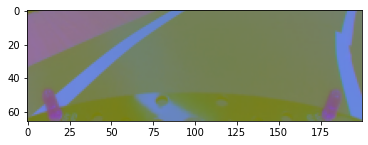

In [ ]:
image_index = 32
plt.imshow(Image.open(image_paths[image_index]))
print("image_path : %s" % image_paths[image_index])
print("steering_Angle : %d" % steering_angles[image_index])
df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Angle'] = steering_angles

(array([7561.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 21202.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        7923.0000]),
 array([45.0000, 48.6000, 52.2000, 55.8000, 59.4000, 63.0000, 66.6000,
        70.2000, 73.8000, 77.4000, 81.0000, 84.6000, 88.2000, 91.8000,
        95.4000, 99.0000, 102.6000, 106.2000, 109.8000, 113.4000, 117.0000,
        120.6000, 124.2000, 127.8000, 131.4000, 135.0000]),
 <a list of 25 Patch objects>)

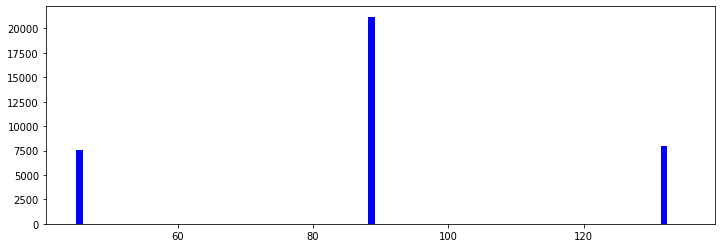

In [ ]:
num_of_bins = 25
hist, bins = np.histogram(df['Angle'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize = (12, 4))
axes.hist(df['Angle'], bins = num_of_bins, width = 1, color = 'blue')

Training data : 29348
Validation data : 7338


Text(0.5, 1.0, 'Validation Data')

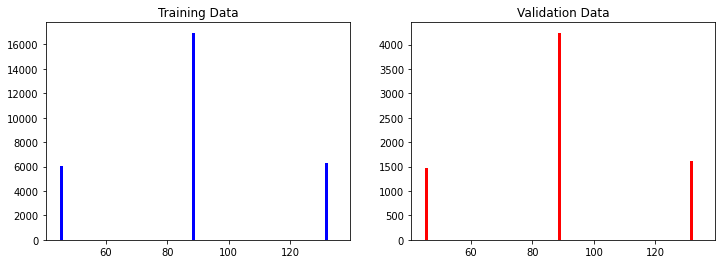

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steering_angles, test_size = 0.2)
print("Training data : %d\nValidation data : %d" % (len(X_train), len(X_valid)))

fig, axes = plt.subplots(1,2, figsize = (12, 4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color = 'blue')
axes[0].set_title('Training Data')
axes[1].hist(y_valid, bins = num_of_bins, width = 1, color = 'red')
axes[1].set_title('Validation Data')

Text(0.5, 1.0, 'processed')

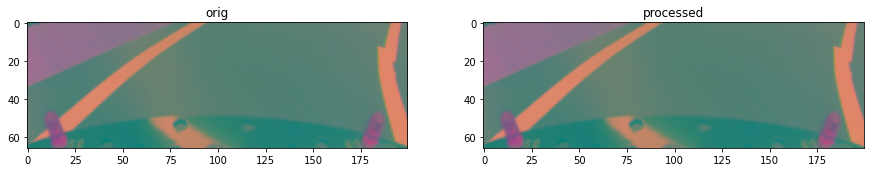

In [ ]:
def my_imread(image_path):
  image = cv2.imread(image_path)
  return image

def img_preprocess(image):
  #image = cv2.resize(image, (66,200,1))
  image = image / 255
  return image

fig, axes = plt.subplots(1, 2, figsize=(15,10))
image_orig = my_imread(image_paths[image_index])

#for i in range(3):
 # augmented_image = data_augmentation(image_orig)

image_processed = img_preprocess(image_orig)

axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_processed)
axes[1].set_title("processed")

### NVIDIA_MODEL

In [ ]:
def nvidia_model():
    model = Sequential(name = 'Nvidia_Model')

    model.add(Conv2D(24, (5,5), strides = (2,2), input_shape = (66, 200, 3), activation = 'relu'))
    model.add(Conv2D(36, (5,5), strides = (2,2), activation = 'relu'))
    model.add(Conv2D(48, (5,5), strides = (2,2), activation = 'relu'))
    model.add(Conv2D(64, (3,3), activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3,3), activation = 'relu'))

    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(100, activation = 'relu'))
    model.add(Dense(50, activation = 'relu'))
    model.add(Dense(10, activation = 'relu'))

    model.add(Dense(1))
    
    optimizer = Adam(lr = 1e-3)
    model.compile(loss = 'mse', optimizer = optimizer)

    return model

model = nvidia_model()
print(model.summary())


Model: "Nvidia_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 dropout (Dropout)           (None, 3, 20, 64)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 1152)             

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Custom CNN lite

In [ ]:
def CNN_custom():
    model = Sequential(name = 'CNN_custom1')

    model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(66, 200, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation = 'relu'))
    model.add(Dense(10, activation = 'relu'))
    model.add(Dense(1))

    return model

with tf.device('/gpu:0'):
  model = CNN_custom()
  model.compile(loss='mse', optimizer='adam')
  print(model.summary())

Model: "CNN_custom1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 198, 32)       896       
                                                                 
 conv2d_7 (Conv2D)           (None, 62, 196, 64)       18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 98, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 31, 98, 64)        0         
                                                                 
 flatten_3 (Flatten)         (None, 194432)            0         
                                                                 
 dense_12 (Dense)            (None, 128)               24887424  
                                                       

### ResNet Lite

In [ ]:
def identity_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    
    # Add
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    return X

In [ ]:
def convolutional_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)

    X_shortcut = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X_shortcut)
    X_shortcut = tf.keras.layers.BatchNormalization()(X_shortcut)
    
    # Add
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    return X

In [ ]:
def ResNetLite(input_shape = (66, 200, 3), classes = 1):
    X_input = tf.keras.layers.Input(input_shape)
    X = X_input
    
    X = tf.keras.layers.Conv2D(64, (3,3), padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)

    X = identity_block(X, 64, (3,3))
    X = identity_block(X, 64, (3,3))    
    
    X = tf.keras.layers.GlobalAveragePooling2D()(X)
    X = tf.keras.layers.Dense(1, activation = 'softmax')(X)

    model = tf.keras.models.Model(inputs = X_input, outputs = X, name = "ResNet50")
    model.compile(loss='mse', optimizer='adam')
    return model

In [ ]:

model = ResNetLite()
print(model.summary())

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 66, 200, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 66, 200, 64)  1792        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 66, 200, 64)  256        ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                           

### GoogleNet

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout,AveragePooling2D,Dense,Conv2D,MaxPooling2D,Activation,Concatenate,GlobalAveragePooling2D,Flatten
from tensorflow.keras import Input

def inception(x_in, x1_f,x3r_f,x3_f,x5r_f,x5_f,po):
    
    x1 = MaxPooling2D(pool_size=(3,3),strides=(1,1),padding = 'SAME')(x_in)
    x1 = Conv2D(filters= po,kernel_size=(1,1),padding="SAME")(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv2D(filters=x5r_f,kernel_size=(1,1),padding="SAME")(x_in)
    x2 = Conv2D(filters=x5_f,kernel_size=(5,5),padding="SAME")(x2)
    x2 = Activation('relu')(x2)

    x3 = Conv2D(filters=x3r_f,kernel_size=(1,1),padding="SAME")(x_in)
    x3 = Conv2D(filters=x3_f,kernel_size=(3,3),padding="SAME")(x3)
    x3 = Activation('relu')(x3)

    x4 = Conv2D(filters=x1_f,kernel_size=(1,1),padding="SAME")(x_in)
    x4 = Activation('relu')(x4)

    out = Concatenate()([x1,x2,x3,x4])
    return out


input_data = Input(shape=(66,200,3))
x = Conv2D(filters=64,kernel_size=(7,7),strides=(2,2),padding="SAME")(input_data)
x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding="SAME")(x)
x = tf.keras.layers.LayerNormalization()(x)

x = Conv2D(filters=64,kernel_size=(1,1),strides=(1,1),padding="SAME")(x)
x = Conv2D(filters=192,kernel_size=(3,3),strides=(1,1),padding="SAME")(x)

x = tf.keras.layers.LayerNormalization()(x)
x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding="SAME")(x)


x = inception(x,64,96,128,16,32,32)
x = inception(x,128,128,192,32,96,64)

x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding="SAME")(x)
x = inception(x,192,96,208,16,48,64)

ax1 = AveragePooling2D(pool_size=(5,5),strides=(3,3))(x)
ax1 = Conv2D(filters=128,kernel_size=(1,1),padding="SAME")(ax1)
ax1 = Flatten()(ax1)
ax1 = Dense(1024,activation="relu")(ax1)
ax1 = Dropout(0.7)(ax1)
ax1 = Dense(1,activation="softmax")(ax1)

x = inception(x,160,112,224,24,64,64)
x = inception(x,128,128,256,24,64,64)

x = inception(x,112,114,288,32,64,64)

ax2 = AveragePooling2D(pool_size=(5,5),strides=(3,3))(x)
ax2 = Conv2D(filters=128,kernel_size=(1,1),padding="SAME")(ax2)
ax2 = Flatten()(ax2)
ax2 = Dense(1024,activation="relu")(ax2)
ax2 = Dropout(0.7)(ax2)
ax2 = Dense(1,activation="softmax")(ax2)

x = inception(x,256,160,320,32,128,128)
x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding="SAME")(x)

x = inception(x,256,160,320,32,128,128)
x = inception(x,384,192,384,48,128,128)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)

outputs = Dense(1,activation="softmax")(x)
googlenet = tf.keras.models.Model(input_data,[outputs,ax1,ax2],name = 'googlenet')
googlenet.summary()

Model: "googlenet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 66, 200, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_125 (Conv2D)            (None, 33, 100, 64)  9472        ['input_4[0][0]']                
                                                                                                  
 max_pooling2d_27 (MaxPooling2D  (None, 17, 50, 64)  0           ['conv2d_125[0][0]']             
 )                                                                                                
                                                                                          

In [ ]:
googlenet.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

### training operation

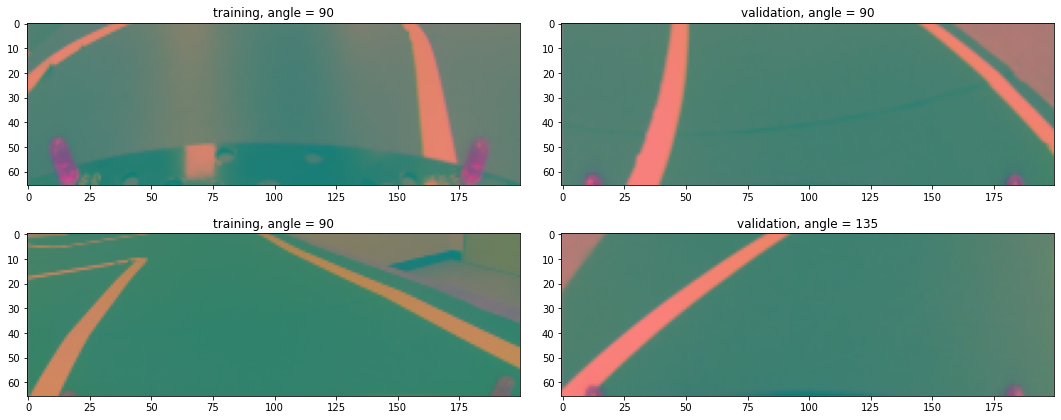

In [ ]:
def image_data_generator(image_paths, steering_angles, batch_size):
  while True:
    batch_images = []
    batch_streering_angles = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      image_path = image_paths[random_index]
      image = my_imread(image_paths[random_index])
      steering_angle = steering_angles[random_index]

      image = img_preprocess(image)
      batch_images.append(image)
      batch_streering_angles.append(steering_angle)
    
    yield(np.asarray(batch_images), np.asarray(batch_streering_angles))

ncol = 2
nrow = 2

X_train_batch, y_train_batch = next(image_data_generator(X_train, y_train, nrow))
X_valid_batch, y_valid_batch = next(image_data_generator(X_valid, y_valid, nrow))

fig, axes = plt.subplots(nrow, ncol, figsize = (15,6))
fig.tight_layout()

for i in range(nrow):
  axes[i][0].imshow(X_train_batch[i])
  axes[i][0].set_title("training, angle = %s" % y_train_batch[i])
  axes[i][1].imshow(X_valid_batch[i])
  axes[i][1].set_title("validation, angle = %s" % y_valid_batch[i])                                                            

In [ ]:
model_output_dir = "/content/drive/MyDrive/artificial_control/model"

checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir, 'lane_navigation_check_total.h5'), 
                                                                verbose=1, save_best_only =True)

history = model.fit(image_data_generator(X_train, y_train, batch_size=80), steps_per_epoch=300, epochs= 30, 
                                                  validation_data=image_data_generator(X_valid, y_valid, batch_size=100),
                                                  validation_steps=200, verbose=1, shuffle=1, callbacks = [checkpoint_callback])

model.save(os.path.join(model_output_dir, 'lane_navigation_final_total.h5'))

history_path = os.path.join(model_output_dir, 'history.pickle')

with open(history_path, 'wb') as f:
  pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)

Epoch 1/30
 36/300 [==>...........................] - ETA: 3:50:36 - loss: 2622.8164

In [ ]:
history.history

history_path = os.path.join(model_output_dir, 'history.pickle')

with open(history_path, 'rb') as f:
  history = pickle.load(f)


history
plt.plot(history['loss'], color = 'blue')
plt.plot(history['val_loss'], color = 'red')
plt.legend(['training loss', 'validation loss'])

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):
  mse = mean_squared_error(Y_true, Y_pred)
  r_squared = r2_score(Y_true, Y_pred)

  print(f'mse = {mse:.2}')
  print(f'r_squared = {r_squared:.2%}')
  print()

def predict_and_summarize(X, Y):
  model = load_model(f'{model_output_dir}/lane_navigation_check.h5')
  Y_pred = model.predict(X)
  summarize_prediction(Y, Y_pred)
  return Y_pred

n_tests = 100
X_test, y_test = next(image_data_generator(X_valid, y_valid, 100))

y_pred = predict_and_summarize(X_test, y_test)

n_tests_show = 3
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10,4 * n_tests_show))
for i in range(n_tests_show):
  axes[i].imshow(X_test[i])
  axes[i].set_title(f"actual angle = {y_test[i]}, predicted angle = {int(y_pred[i])}, diff = {int(y_pred[i])-y_test[i]}")